In [1]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
default_params = dict(
    t1 = 3.1,    # Singlet lifetime, Nest 2014 p2
    t3 = 24,     # Triplet lifetime, Nest 2014 p2
    fs = 0.2,    # Singlet fraction
    tts = 2.,     # Transit time spread.
    f_r = 0.,
    tr = 15,
    fs_r = 0.2,
    eta = 0.,
    
    s1_min=30,
    s1_max=100,
    dset='er',
    # pulse_model=1, # This is the CHANNEL that is used...
    aft = 0.5, # 0.28
    n_photons = int(2e5),
    t_min = -8.,
    t_max = 200.,
    s1_sample = 'data', # 'uniform'
    error_offset  = 1e-4 , 
    error_pct = 0.,
    neglect_statistical = False,
    neglect_systematic = True,
    spe_model = 'expnorm', # template, expnorm, hybrid?
    s1_model = 'two_exp', # two_exp, recombination, recombination2
)

In [3]:
d = xams_data['nr']

In [6]:
d.keys()

Index(['run_number', 'event_number', 's1_area_midpoint', 's1_center_time',
       's1_left', 's1_n_saturated_channels', 's1_range_20p_area',
       's1_range_80p_area', 's1_right', 's1_time_from_midpoint_10p',
       's1_time_from_midpoint_20p', 's1_time_from_midpoint_30p',
       's1_time_from_midpoint_40p', 'event_duration', 'event_time', 'cs1',
       'cs2', 'drift_time', 'largest_coincidence', 'largest_other_s1',
       'largest_other_s2', 'largest_unknown', 'largest_veto', 's1',
       's1_area_fraction_top', 's1_range_50p_area', 's2',
       's2_area_fraction_top', 's2_range_50p_area', 'x', 'y', 'z', 's2_bot',
       'cs2b', 't', 'ms_since_previous_event', 's2_width_difference',
       's1_10_percentile_point_pax', 's1_20_percentile_point_pax',
       's1_30_percentile_point_pax', 's1_40_percentile_point_pax'],
      dtype='object')

(array([ 14160.,   3877.,   1720.,   1506.,    783.,    541.,    414.,
           410.,    432.,    427.]),
 array([   1.31021838,   41.17522083,   81.04022329,  120.90522574,
         160.77022819,  200.63523064,  240.50023309,  280.36523554,
         320.23023799,  360.09524044,  399.9602429 ]),
 <a list of 10 Patch objects>)

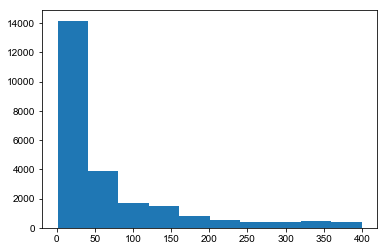

In [7]:
plt.hist(d['cs1'])

### Recombination 2

In [4]:
p = dict(
    s1_model = 'recombination'
)

{'tts': 2.0, 'spe_model': 'expnorm', 'neglect_statistical': False, 's1_min': 30, 'tr': 15, 's1_model': 'recombination', 'eta': 0.0, 'fs': 0.2, 'neglect_systematic': True, 'fs_r': 0.2, 's1_max': 100, 's1_sample': 'data', 'n_photons': 200000, 'error_pct': 0.0, 't3': 24, 'dset': 'er', 'error_offset': 0.0001, 't_min': -8.0, 'aft': 0.5, 't_max': 200.0, 'f_r': 0.0, 't1': 3.1}


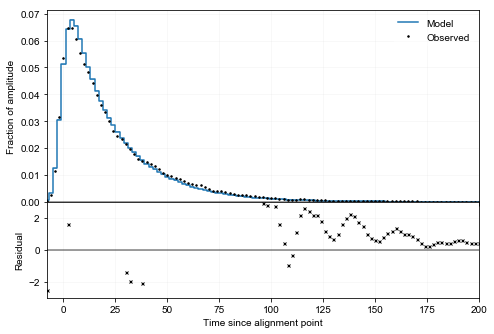

chi2 = 47.078483


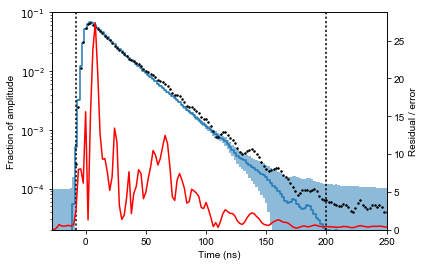

In [5]:
plot_model(**p)

In [7]:
minimize_it(['fs', 't3'], [0.2, 24.], **p)

gof=43.598244775734535, fs=0.2, t1=3.1, t3=24.0, tts=2.0
gof=40.543779419594635, fs=0.2, t1=3.1, t3=24.0, tts=2.0
gof=7335.058920303647, fs=1, t1=3.1, t3=24.0, tts=2.0
gof=173.57659826020407, fs=0, t1=3.1, t3=24.0, tts=2.0
gof=42.0790009417838, fs=0.2, t1=3.1, t3=24.0, tts=2.0
gof=209.66489705577433, fs=0, t1=3.1, t3=24.0, tts=2.0
gof=1580.340484166692, fs=0.581966, t1=3.1, t3=24.0, tts=2.0
gof=226.1881633063835, fs=0, t1=3.1, t3=24.0, tts=2.0
gof=269.78326308833874, fs=0.34589802515600004, t1=3.1, t3=24.0, tts=2.0
gof=79.00483393055576, fs=0.09401401696707583, t1=3.1, t3=24.0, tts=2.0
gof=100.22731479938183, fs=0.2557280850767367, t1=3.1, t3=24.0, tts=2.0
gof=33.194866004110814, fs=0.16724711461657396, t1=3.1, t3=24.0, tts=2.0
gof=36.691766291997325, fs=0.1675949323848563, t1=3.1, t3=24.0, tts=2.0
gof=46.96446350588663, fs=0.13927456123978577, t1=3.1, t3=24.0, tts=2.0
gof=39.62124049900278, fs=0.15656255029345567, t1=3.1, t3=24.0, tts=2.0
gof=36.04742468733804, fs=0.1622162070301732, 

   direc: array([[ 1.,  0.],
       [ 0.,  1.]])
     fun: 11.5954355427293
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  0.20658024,  26.98509037])

In [16]:
p = dict(
    dset = 'er_0',
    s1_model = 'recombination2',
    t3 = 24.,
    eta = 0.5,
    f_r = 0.5
    
)

{'tts': 2.0, 'spe_model': 'expnorm', 'neglect_statistical': False, 's1_min': 30, 'tr': 15, 's1_model': 'recombination2', 'eta': 0.5, 'fs': 0.2, 'neglect_systematic': True, 'fs_r': 0.2, 's1_max': 100, 's1_sample': 'data', 'n_photons': 200000, 'error_pct': 0.0, 't3': 24.0, 'dset': 'er_0', 'error_offset': 0.0001, 't_min': -8.0, 'aft': 0.5, 't_max': 200.0, 'f_r': 0.5, 't1': 3.1}


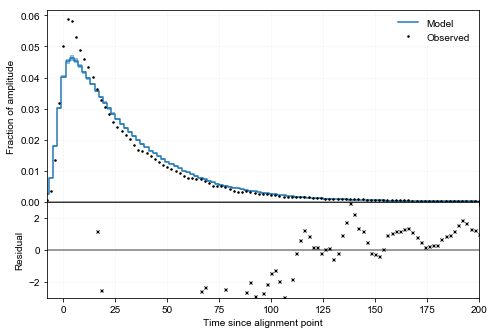

chi2 = 38.352329


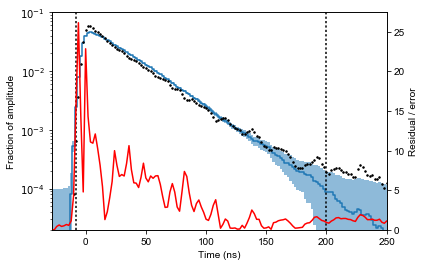

In [17]:
plot_model(**p)

{'tts': 2.0, 'spe_model': 'expnorm', 'neglect_statistical': False, 's1_min': 30, 'tr': 15, 's1_model': 'recombination2', 'eta': 0.0, 'fs': 0.2, 'neglect_systematic': True, 'fs_r': 0.2, 's1_max': 100, 's1_sample': 'data', 'n_photons': 200000, 'error_pct': 0.0, 't3': 24.0, 'dset': 'er_0', 'error_offset': 0.0001, 't_min': -8.0, 'aft': 0.5, 't_max': 200.0, 'f_r': 0.5, 't1': 3.1}


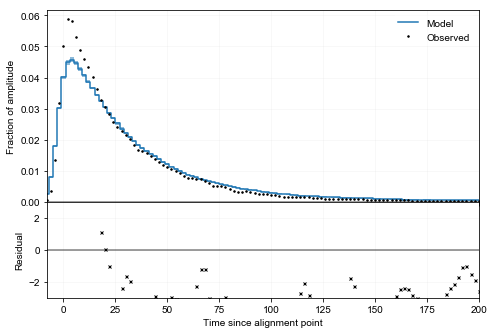

chi2 = 41.570871


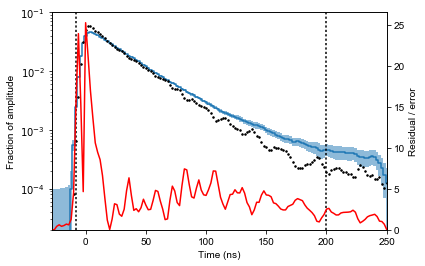

In [18]:
p['eta'] = 0.0
plot_model(**p)

In [109]:
def produce_settings_dicts(scan_params, lower_bounds, upper_bounds, step_sizes, block_size, **p):
    x = []
    nsteps = (np.array(upper_bounds) - np.array(lower_bounds)) / np.array(step_sizes) + 1
    for param, l, u, ns in zip(scan_params, lower_bounds, upper_bounds, nsteps):
        x.append(np.linspace(l, u, ns))
    n_sim  = int(np.product(nsteps))
    x = np.meshgrid(*x)
    par_vals = [_x.flatten() for _x in x]
    dicts = []
    for i in range(n_sim):
        for j, par in enumerate(scan_params):
            p[par] = par_vals[j][i]
        dicts.append(deepcopy(p))
    dicts = np.array(dicts)
    print('Loaded %d settings.' % len(dicts))
    if len(dicts) <= block_size:
        return dicts
    else:
        n_blocks = int(len(dicts) / block_size)
        return np.array_split(dicts, n_blocks)
            


In [113]:
x = produce_settings_dicts(['t3', 'fs', 'bla'], [22, 0.18, 0], [27, 0.22, 1], [1, 0.01, 1], 10, **p)

Loaded 60 settings.


In [119]:
def dump_settings_pickles(x, dirname, base_name):
    for i, _x in enumerate(x):
        fn = os.path.join(dirname, base_name + '_%03d.pickle' % i)
        with open(fn, 'wb') as f:
            pickle.dump(_x, f)
    print('Dumping done.')

In [120]:
dump_settings_pickles(x, '.', 'bla')

Dumping done.


In [121]:
def process_the_pickle(fn):
    with open(fn, 'rb') as f:
        dicts = pickle.load(f)
    for p in dicts:
        p['chi2'] = gof(**p)
    with open(fn, 'wb') as f:
        pickle.dump(dicts, f)
    print('Done')

In [123]:
process_the_pickle('bla_000.pickle')

gof=21.168969381991523, fs=0.18, t1=3.1, t3=22.0, tts=2.0
gof=21.748224798124767, fs=0.18, t1=3.1, t3=22.0, tts=2.0
gof=29.24551537607638, fs=0.18, t1=3.1, t3=23.0, tts=2.0
gof=30.394114629764367, fs=0.18, t1=3.1, t3=23.0, tts=2.0
gof=37.57430096147898, fs=0.18, t1=3.1, t3=24.0, tts=2.0
gof=33.265457871509724, fs=0.18, t1=3.1, t3=24.0, tts=2.0
gof=57.92486860742699, fs=0.18, t1=3.1, t3=25.0, tts=2.0
gof=38.69855664394244, fs=0.18, t1=3.1, t3=25.0, tts=2.0
gof=50.96438291619896, fs=0.18, t1=3.1, t3=26.0, tts=2.0
gof=58.66495957560209, fs=0.18, t1=3.1, t3=26.0, tts=2.0
Done


In [124]:
bla = pickle.load(open('bla_000.pickle', 'rb'))

In [125]:
bla

array([ {'f_r': 0.5, 'bla': 0.0, 't3': 22.0, 'dset': 'er_0', 'eta': 0.0, 's1_model': 'recombination2', 'fs': 0.17999999999999999, 'chi2': 21.168969381991523},
       {'f_r': 0.5, 'bla': 1.0, 't3': 22.0, 'dset': 'er_0', 'eta': 0.0, 's1_model': 'recombination2', 'fs': 0.17999999999999999, 'chi2': 21.748224798124767},
       {'f_r': 0.5, 'bla': 0.0, 't3': 23.0, 'dset': 'er_0', 'eta': 0.0, 's1_model': 'recombination2', 'fs': 0.17999999999999999, 'chi2': 29.24551537607638},
       {'f_r': 0.5, 'bla': 1.0, 't3': 23.0, 'dset': 'er_0', 'eta': 0.0, 's1_model': 'recombination2', 'fs': 0.17999999999999999, 'chi2': 30.394114629764367},
       {'f_r': 0.5, 'bla': 0.0, 't3': 24.0, 'dset': 'er_0', 'eta': 0.0, 's1_model': 'recombination2', 'fs': 0.17999999999999999, 'chi2': 37.574300961478983},
       {'f_r': 0.5, 'bla': 1.0, 't3': 24.0, 'dset': 'er_0', 'eta': 0.0, 's1_model': 'recombination2', 'fs': 0.17999999999999999, 'chi2': 33.265457871509724},
       {'f_r': 0.5, 'bla': 0.0, 't3': 25.0, 'dset': 